In [1]:
import pandas as pd
import numpy as np
import sqlite3
import matplotlib.pyplot as plt
%matplotlib inline
plt.rc("figure", figsize=(12.0, 8.0))
import seaborn as sns
sns.set(color_codes=True)

from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score

# Data Input

In [2]:
conn = sqlite3.connect("salaries.db")
columns = ["File_Date",
           "SubAgency", 
           "Age_Range",
           "Education_Level",
           "Pay_Plan",
           "Grade",
           "LOS_Level",
           "Occupation",
           "PATCO",
           "Adjusted_Basic_Pay",
           "Supervisory_Status",
           "TOA",
           "Work_Schedule",
           "NSFTP_Indicator"]

In [3]:
num_employees = pd.read_sql_query("""
SELECT 
    File_Date AS Date, 
    Occupation,
    COUNT(*) AS Number_Employees 
FROM 
    (SELECT
        File_Date,
        REPLACE(Occupation, '1169', '0512') AS Occupation
     FROM 
         data) sub
WHERE
    File_Date LIKE '%03'
    AND Occupation IN ('0512')
GROUP BY
    File_Date,
    Occupation
;""", conn)
num_employees["Date"] = pd.to_datetime(num_employees["Date"], format="%Y%m")
num_employees["Occupation"] = num_employees["Occupation"].map({"0512": "Internal Revenue Service"})

In [4]:
total_salaries = pd.read_sql_query("""
SELECT 
    File_Date AS Date, 
    REPLACE(Occupation, "1169", "0512") AS Occupation,
    SUM(Adjusted_Basic_Pay) AS Total_Budget 
FROM 
    (SELECT
        File_Date,
        REPLACE(Occupation, '1169', '0512') AS Occupation,
        Adjusted_Basic_Pay
     FROM 
         data) sub
WHERE
    File_Date LIKE '%03'
    AND Occupation IN ('0512')
GROUP BY
    File_Date, 
    Occupation
;""", conn)
total_salaries["Date"] = pd.to_datetime(total_salaries["Date"], format="%Y%m")
total_salaries["Occupation"] = total_salaries["Occupation"].map({"0512": "Internal Revenue Service"})

In [5]:
average_salaries = pd.read_sql_query("""
SELECT 
    File_Date AS Date, 
    Occupation,
    AVG(Adjusted_Basic_Pay) AS Average_Salary
FROM 
    (SELECT
        File_Date,
        REPLACE(Occupation, '1169', '0512') AS Occupation,
        Adjusted_Basic_Pay
     FROM 
         data) sub
WHERE
    File_Date LIKE '%03'
    AND Occupation IN ('0512')
GROUP BY
    File_Date, 
    Occupation
;""", conn)
average_salaries["Date"] = pd.to_datetime(average_salaries["Date"], format="%Y%m")
average_salaries["Occupation"] = average_salaries["Occupation"].map({"0512": "Internal Revenue Service"})

In [6]:
IRS = pd.read_csv("IRS_data_summary.csv", thousands=",").rename(columns={"Audit Year": "Year"})
IRS.set_index("Year", inplace=True)
IRS.sort_index(inplace=True)
IRS["Exam coverage"] = (IRS["Individual returns examined (total)"] / IRS["Individual returns filed"])
IRS["Corporate exam coverage"] = (IRS["Corporate returns examined (total)"] / IRS["Corporate returns filed"])
IRS["Total recommended tax"] = (IRS["Recommended additional tax (total)"] + 
                                IRS["Recommended additional corporate tax (total)"])

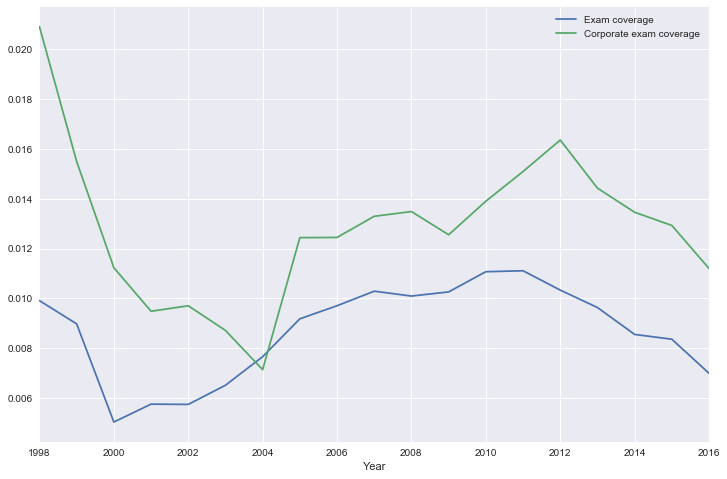

In [7]:
IRS[["Exam coverage", "Corporate exam coverage"]].plot()

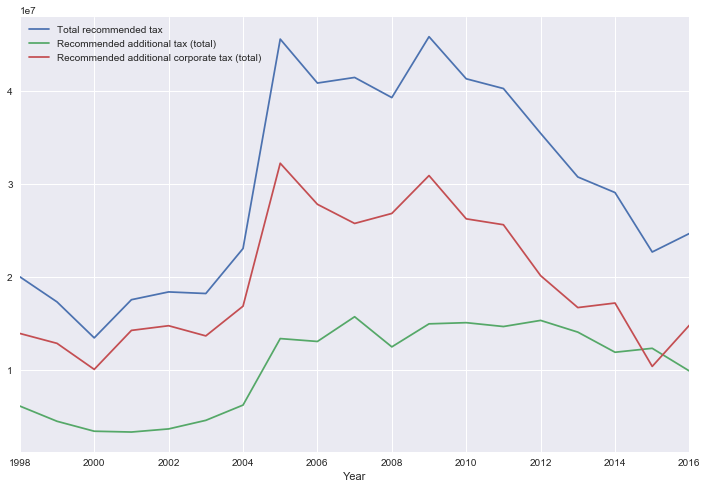

In [8]:
IRS[["Total recommended tax", "Recommended additional tax (total)", "Recommended additional corporate tax (total)"]].plot()

# IRS Performance Regressions

Some helper code for fitting and plotting linear models:

In [9]:
# IRS employee count each year from 1998-2016
recent_IRS_employee_counts = num_employees[(num_employees["Date"] > "1998-01-01") & (num_employees["Date"] < "2017-01-01")]["Number_Employees"].as_matrix().reshape(-1, 1)


def linear_regression(X, y, year_limit=None):
    """
    Given n-dimensional vectors X and y, fits a least-squares linear model.
    If year_limit is specified, the model uses only the last year_limit years of data.
    """
    # Only use data from the past year_limit years
    if year_limit:
        X = X[-year_limit:]
        y = y[-year_limit:]
    
    # Create linear regression model
    model = linear_model.LinearRegression()

    # Fit the model
    model.fit(X, y)

    # Make in-sample predictions
    y_predicted = model.predict(X)

    # Show parameters of the model
    print('Slope:\t\t', model.coef_[0])
    print('Intercept:\t', model.intercept_)

    # Mean squared error
    print("Mean squared error:\t%.2f" % mean_squared_error(y, y_predicted))

    # Explained variance score (1 is perfect prediction)
    print('Variance/R^2 score:\t%.2f' % r2_score(y, y_predicted))

    # Plot data points and fitted line
    plt.scatter(X, y, color='black')
    plt.plot(X, y_predicted, color='blue', linewidth=3)

### IRS Head Count vs. Exam Coverage

Slope:		 6.14238046937e-07
Intercept:	 -0.00129864916056
Mean squared error:	0.00
Variance/R^2 score:	0.97


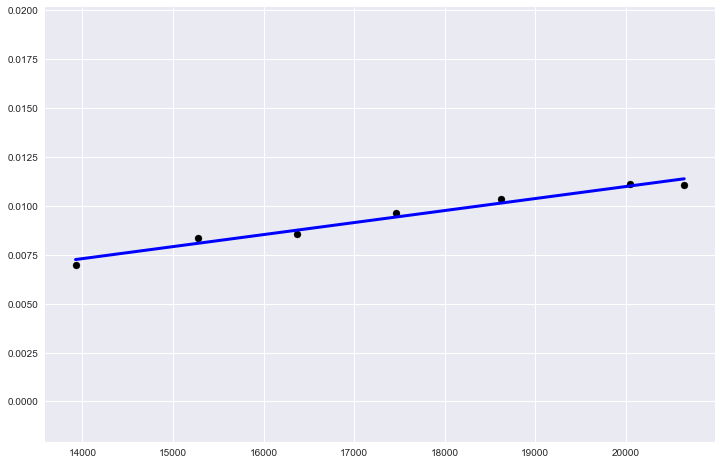

In [10]:
# IRS employee count each year
X = recent_IRS_employee_counts

# Percent of returns audited each year
y = IRS["Exam coverage"].as_matrix()

# Fit a linear model using only 2010-2016 data
linear_regression(X, y, year_limit=7)

### IRS Head Count vs. Recovered Taxes

Slope:		 744.970871577
Intercept:	 284038.99284
Mean squared error:	567513822723.44
Variance/R^2 score:	0.84


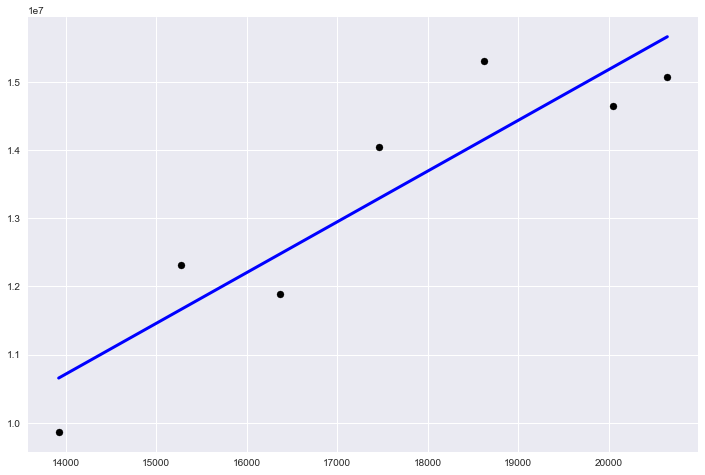

In [11]:
# IRS employee count each year
X = recent_IRS_employee_counts

# Tax dollars recovered each year
y = IRS["Recommended additional tax (total)"].as_matrix()

# Fit a linear model using only 2010-2016 data
linear_regression(X, y, year_limit=7)

# Data Exploration

In [12]:
num_employees[(num_employees["Date"] > "1998-01-01") & (num_employees["Date"] < "2017-01-01")]["Number_Employees"]

24    21668
25    20778
26    19864
27    18676
28    18462
29    18135
30    18170
31    18448
32    18557
33    18851
34    18557
35    18293
36    20646
37    20051
38    18626
39    17464
40    16369
41    15274
42    13923
Name: Number_Employees, dtype: int64

In [13]:
IRS["Exam coverage"]

Year
1998    0.009912
1999    0.008978
2000    0.005040
2001    0.005757
2002    0.005747
2003    0.006516
2004    0.007662
2005    0.009183
2006    0.009707
2007    0.010291
2008    0.010095
2009    0.010262
2010    0.011072
2011    0.011110
2012    0.010335
2013    0.009635
2014    0.008555
2015    0.008362
2016    0.006994
Name: Exam coverage, dtype: float64

In [14]:
IRS["Recommended additional tax (total)"]

Year
1998     6095698
1999     4458474
2000     3388905
2001     3301860
2002     3636486
2003     4559902
2004     6201693
2005    13355087
2006    13045221
2007    15705155
2008    12462770
2009    14940892
2010    15066486
2011    14652239
2012    15310908
2013    14049657
2014    11885411
2015    12308319
2016     9864674
Name: Recommended additional tax (total), dtype: int64

In [15]:
# conn.close()